In [3]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import warnings
warnings.filterwarnings('ignore')

# Data Preparation and Exploration

In [4]:
data = pd.read_csv("exchange_rate (4).csv")


In [5]:
data

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


In [6]:
data.columns

Index(['date', 'Ex_rate'], dtype='object')

In [7]:
data.shape

(7588, 2)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [9]:
data['date'] = pd.to_datetime(data['date'], format='%d-%m-%Y %H:%M')
data.set_index('date', inplace=True)

In [10]:
# Check for missing values and data info
print(data.info())
print("\nMissing Values:\n", data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7588 entries, 1990-01-01 to 2010-10-10
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6 KB
None

Missing Values:
 Ex_rate    0
dtype: int64


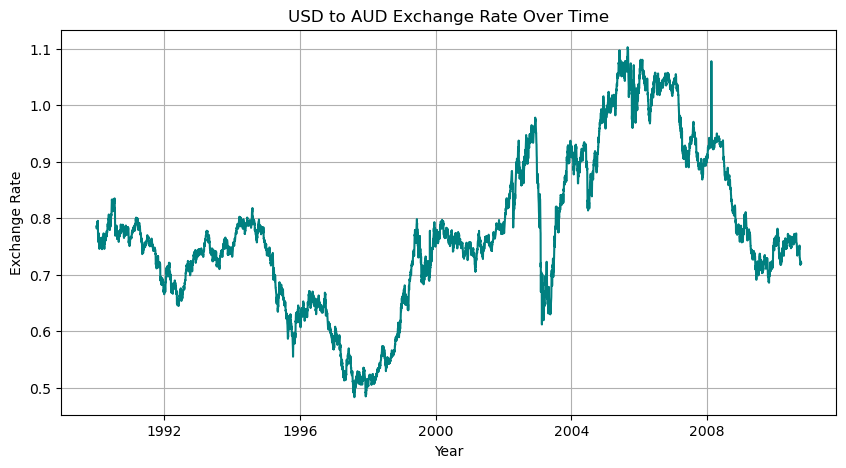

In [11]:
# Plot the time series
plt.figure(figsize=(10,5))
plt.plot(data, color='teal')
plt.title('USD to AUD Exchange Rate Over Time')
plt.xlabel('Year')
plt.ylabel('Exchange Rate')
plt.grid(True)
plt.show()

In [12]:
# Handle missing values (if any)
data = data.interpolate(method='linear')

In [13]:
# Perform stationarity test (ADF test)
result = adfuller(data.iloc[:, 0])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -1.6649941807381343
p-value: 0.44923273535979974


In [14]:
if result[1] < 0.05:
    print("✅ The series is stationary.")
else:
    print("⚠️ The series is non-stationary, differencing required.")

⚠️ The series is non-stationary, differencing required.


If p-value > 0.05, data is non-stationary, so differencing is needed before ARIMA modeling.

# Model Building-ARIMA

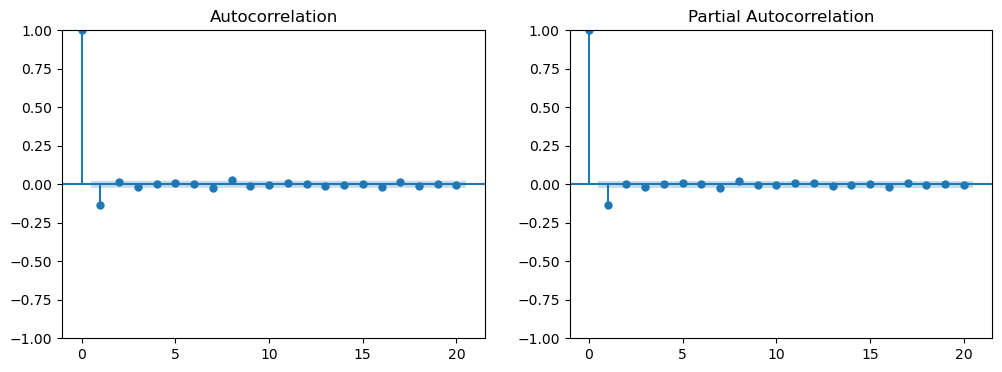

In [15]:
# Visualize ACF and PACF to determine p, q
fig, axes = plt.subplots(1, 2, figsize=(12,4))
plot_acf(data.diff().dropna(), lags=20, ax=axes[0])
plot_pacf(data.diff().dropna(), lags=20, ax=axes[1])
plt.show()

In [16]:
# Fit ARIMA model (example with p=1, d=1, q=1 — adjust if needed)
model_arima = ARIMA(data, order=(1,1,1))
model_arima_fit = model_arima.fit()

In [17]:
# Model summary
print(model_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Mon, 17 Nov 2025   AIC                         -56102.322
Time:                        15:26:12   BIC                         -56081.519
Sample:                    01-01-1990   HQIC                        -56095.182
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

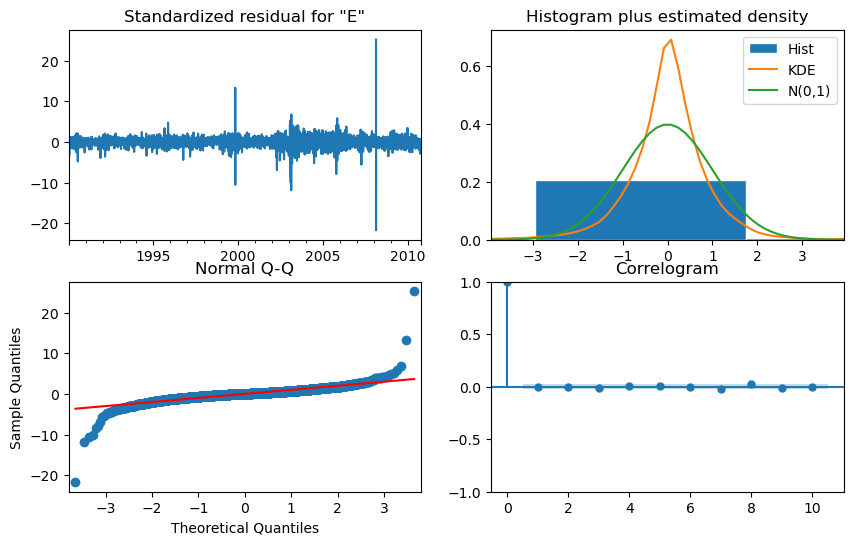

In [18]:
# Residual diagnostics
model_arima_fit.plot_diagnostics(figsize=(10,6))
plt.show()

In [19]:
# Forecast next 30 days
forecast_arima = model_arima_fit.forecast(steps=30)

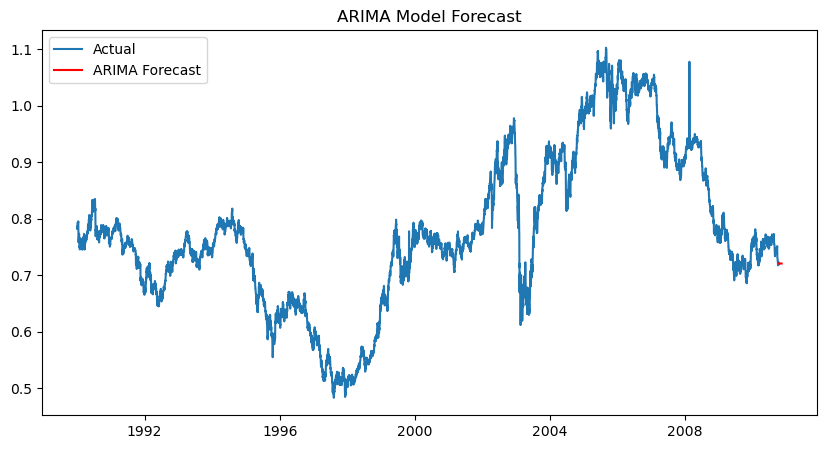

In [20]:
# Plot forecast
plt.figure(figsize=(10,5))
plt.plot(data, label='Actual')
plt.plot(forecast_arima, label='ARIMA Forecast', color='red')
plt.legend()
plt.title("ARIMA Model Forecast")
plt.show()

# Model Building-Exponential Smoothing

In [21]:
# Fit Holt-Winters Exponential Smoothing (with trend and seasonality if needed)
model_hw = ExponentialSmoothing(data, trend='add', seasonal=None).fit()


In [22]:
# Forecast next 30 days
forecast_hw = model_hw.forecast(steps=30)

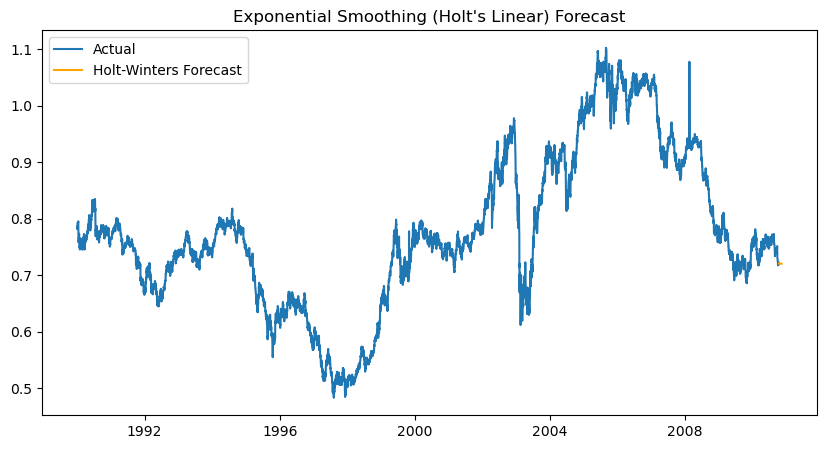

In [23]:
# Plot forecast
plt.figure(figsize=(10,5))
plt.plot(data, label='Actual')
plt.plot(forecast_hw, label='Holt-Winters Forecast', color='orange')
plt.legend()
plt.title("Exponential Smoothing (Holt's Linear) Forecast")
plt.show()

# Evaluation and Comparison

In [24]:
# Split train-test for evaluation
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

In [25]:
# Fit both models on train data
arima_model = ARIMA(train, order=(1,1,1)).fit()
hw_model = ExponentialSmoothing(train, trend='add').fit()

In [26]:
# Forecast same length as test
arima_forecast = arima_model.forecast(steps=len(test))
hw_forecast = hw_model.forecast(steps=len(test))

In [27]:
# Compute error metrics
def evaluate_forecast(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = math.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted)/actual))*100
    return mae, rmse, mape

In [28]:
arima_metrics = evaluate_forecast(test.values, arima_forecast.values)
hw_metrics = evaluate_forecast(test.values, hw_forecast.values)

In [29]:
print("ARIMA -> MAE: {:.4f}, RMSE: {:.4f}, MAPE: {:.2f}%".format(*arima_metrics))
print("Holt-Winters -> MAE: {:.4f}, RMSE: {:.4f}, MAPE: {:.2f}%".format(*hw_metrics))

ARIMA -> MAE: 0.1777, RMSE: 0.2054, MAPE: 22.80%
Holt-Winters -> MAE: 0.1903, RMSE: 0.2201, MAPE: 24.12%


# Comparison Visualization

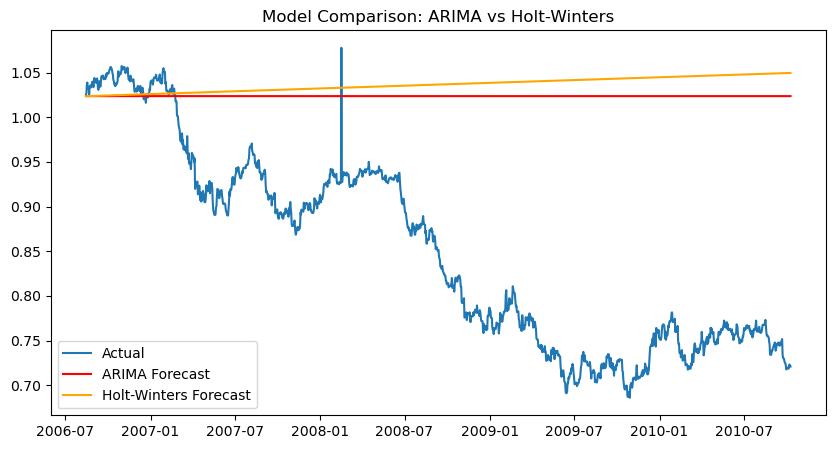

In [30]:
plt.figure(figsize=(10,5))
plt.plot(test.index, test.values, label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='red')
plt.plot(test.index, hw_forecast, label='Holt-Winters Forecast', color='orange')
plt.title("Model Comparison: ARIMA vs Holt-Winters")
plt.legend()
plt.show()

In [ ]:
# Parameter optimization using AIC-based ARIMA grid search
import itertools
import warnings
warnings.filterwarnings('ignore')

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_aic = float('inf')
best_order = None
best_model = None

for order in pdq:
    try:
        model = sm.tsa.ARIMA(y, order=order).fit()
        if model.aic < best_aic:
            best_aic = model.aic
            best_order = order
            best_model = model
    except:
        continue

print('Best ARIMA order:', best_order)
print('Best AIC:', best_aic)
